In [152]:
from os import listdir
from os.path import isfile, join
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import signal
from scipy.optimize import curve_fit
#sns.set(style="darkgrid")

In [153]:
def Noise_Gen(tm,amp):
    noise=[]
    time=[]
    for i in range(tm):
        noise.append(np.random.normal(0,amp))
        time.append(i)
    return np.array(time), np.array(noise)

def Sig_Gen(tm,t0,w,amp):
    s=[]
    t=[]
    for i in range(tm):
        s.append(((np.sqrt(2*np.exp(1)))/w)*amp*(i-t0)*np.exp(-(i-t0)**2/(w**2)))
        t.append(i)
    return np.array(t), np.array(s)

def TS_Correlations(time,data,kernel):
    kernel=0.96787*np.sqrt(2)*kernel/np.sum(np.abs(kernel))
    output=[]
    tout=[]
    for i in range(len(data)):
        if i < len(data)-len(kernel):
            output.append(np.correlate(data[i:i+len(kernel)],kernel)[0])
            tout.append(time[int(i+len(kernel)/2)])
    return(tout,output)


def SNR_Filter(xdata,ydata,filter_kernel):
    fitval=[]
    fiterr=[]
    noise=[]
    rs=[]
    signal_quad=[]
    tval=[]

    i=0
    xdat=[i for i in range(len(filter_kernel))]

    for i in range(len(ydata)-len(filter_kernel)):
        tval.append(xdata[i])
        ydat=ydata[i:i+len(filter_kernel)]
        popt,pcov = curve_fit(filter_func,xdat,ydat)

        fitval.append(popt[0])
        fiterr.append(np.sqrt(pcov[0][0]))

        signal_fitted=filter_func(1,popt)

        residuals = ydat-filter_func(1,popt)

        ss_sig=np.sqrt(np.multiply(np.sum(signal_fitted**2),1))*np.sqrt(len(filter_kernel))
        ss_res = np.sqrt(np.sum(residuals**2))
        ss_tot = np.sum((ydat-np.mean(ydat))**2)

        noise.append(ss_res)
        signal_quad.append(ss_sig)

        r_squared = 1-(ss_res / ss_tot)
        rs.append(r_squared)
    return(tval,fitval,fiterr,signal_quad,noise)



def filter_func(t,a):
    return np.multiply(a,kernel)

def gaussian(x,bb,cc,dd):
    hold=bb*np.exp(-1*(x-cc)**2/(2*dd**2))
    return hold


def TS_Correlations_Fast(time,data,kernel_pass):
    output=signal.correlate(data,kernel_pass,mode='valid',method='fft')
    output=np.divide(output,len(kernel_pass)*np.mean(kernel_pass**2))
    return(time[int(len(kernel_pass)/2)-1:-int(len(kernel_pass)/2)],output)


def SNR_Return_Fast(xdata,ydata,ydatafilt,filter_kernel):
    noise=[]
    signal_quad=[]
    tval=[]
    
    i=0
    xdat=[i for i in range(len(filter_kernel))]

    for i in range(int(len(filter_kernel)/2),len(ydata)-int(len(filter_kernel)/2-1)):
        tval.append(xdata[i])
        ydat=ydata[i-int(len(filter_kernel)/2):i+int(len(filter_kernel)/2)]
        popt=ydatafilt[i-int(len(filter_kernel)/2)]
        signal_fitted=filter_func(1,popt)
        residuals = ydat-filter_func(1,popt)

        ss_sig=np.sqrt(np.multiply(np.sum(signal_fitted**2),1))*np.sqrt(len(filter_kernel))
        ss_res = np.sqrt(np.sum(residuals**2))
        ss_tot = np.sum((ydat-np.mean(ydat))**2)

        noise.append(ss_res)
        signal_quad.append(ss_sig)

    return(np.array(tval),signal_quad,noise)

def SNR_Peak_Search(times,SNRval, width, threshold):
    peaks, _ = find_peaks(SNR_vec, height=threshold,distance=width*2)
    return(tval[peaks], SNR_vec[peaks])

In [154]:
# This notebook is used to explore the impact of width mismatch between 
# a simulated DW signal, and the search kernel, when looking at simulated 
# and potentially noisy data. 

# This sets how coars/fine we need to vary the kernel width when we look 
# for the signal

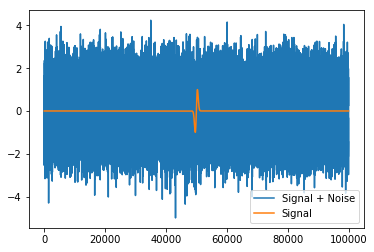

In [155]:
tlen=100000
swidth=500
t, noise =Noise_Gen(tlen,1)
t, sig = Sig_Gen(tlen,50000,swidth,1)
plt.show()
plt.plot(t,sig+noise,label='Signal + Noise')
plt.plot(t,sig,label='Signal')
plt.legend()
plt.show()

# Now we can look at the improvement we get with a matched filter search for a known signal shape, in noisy data. Here we have a signal of amplitude .2, is white noise with amplitude 1. So an SNR of less than 1.

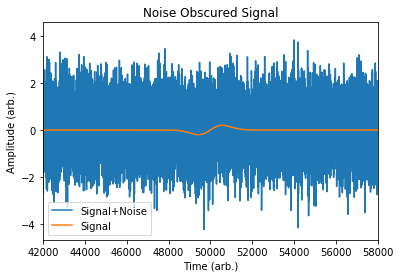

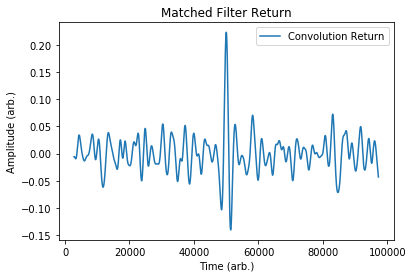

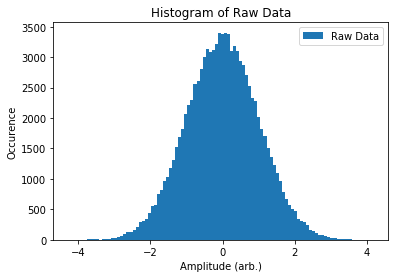

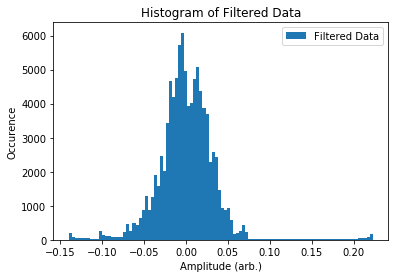

SNR at Peak
9.989985051096806


In [156]:
tlen=100000
swidth=800
t, noise =Noise_Gen(tlen,1)
t, sig = Sig_Gen(tlen,50000,swidth,.2)

plt.plot(t,sig+noise,label='Signal+Noise')
plt.plot(t,sig,label='Signal')
plt.xlim([50000-10*swidth,50000+10*(swidth)])
plt.xlabel("Time (arb.)")
plt.ylabel("Amplitude (arb.)")
plt.title("Noise Obscured Signal")
plt.legend()
plt.show()

data=sig+noise
tmask, kernel=Sig_Gen(int(swidth*7),int(swidth*7/2),swidth,1)
tconv,sigconv=TS_Correlations(t,data,kernel)


plt.plot(tconv,sigconv,label='Convolution Return')
#plt.xlim([50000-10*swidth,50000+10*(swidth)])
plt.legend()
plt.xlabel("Time (arb.)")
plt.ylabel("Amplitude (arb.)")
plt.title("Matched Filter Return")
plt.show()


plt.hist(data,100,label='Raw Data')
plt.legend()
plt.xlabel("Amplitude (arb.)")
plt.ylabel("Occurence")
plt.title("Histogram of Raw Data")
plt.show()

plt.hist(sigconv,100,label='Filtered Data')
plt.xlabel("Amplitude (arb.)")
plt.ylabel("Occurence")
plt.title("Histogram of Filtered Data")
plt.legend()
plt.show()

print("SNR at Peak")
print(np.abs(sigconv[50000-int(7*swidth/2)])/np.std(sigconv[0:20000]))

# As you can see above, the signal is clearly seperated from background after the filter, as shown in the above histogram. SNR goes from less than one, to ~6

# Now we can explore the SNR improvement vs. Width. This is for an original signal, that has an SNR of 1

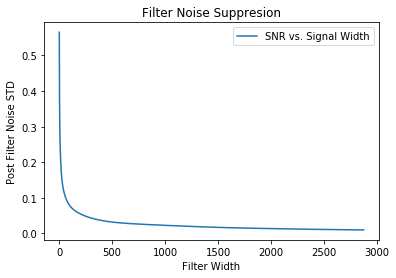

In [157]:
width_vec=[]
noise_vec=[]
swidth=2
for i in range(150):
    data=noise
    tmask, kernel=Sig_Gen(int(swidth*7),int(swidth*7/2),swidth,1)
    tconv,sigconv=TS_Correlations(t,data,kernel)
    
    width_vec.append(swidth)
    noise_vec.append(np.std(sigconv))
    
    swidth=swidth*1.05
    
plt.plot(width_vec,noise_vec,label='SNR vs. Signal Width')
plt.xlabel("Filter Width")
plt.ylabel("Post Filter Noise STD")
plt.title("Filter Noise Suppresion")
plt.legend()
plt.show()

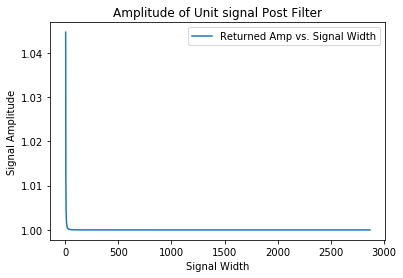

In [158]:
width_vec=[]
sig_vec=[]
swidth=2
for i in range(150):
    t, sig = Sig_Gen(tlen,50000,swidth,1)
    data=sig+noise*0
    tmask, kernel=Sig_Gen(int(swidth*7),int(swidth*7/2),swidth,1)
    tconv,sigconv=TS_Correlations(t,data,kernel)
    width_vec.append(swidth)
    sig_vec.append(np.abs(sigconv[50000-int(7*swidth/2)]))
    swidth=swidth*1.05

plt.plot(width_vec,sig_vec,label='Returned Amp vs. Signal Width')
plt.xlabel("Signal Width")
plt.ylabel("Signal Amplitude")
plt.title("Amplitude of Unit signal Post Filter")
plt.legend()
plt.show()

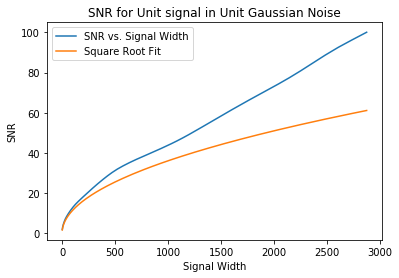

In [159]:
plt.plot(width_vec,np.divide(sig_vec,noise_vec),label='SNR vs. Signal Width')
plt.plot(width_vec,np.sqrt(np.multiply(width_vec,1.3)),label='Square Root Fit')
plt.xlabel("Signal Width")
plt.ylabel("SNR")
plt.title("SNR for Unit signal in Unit Gaussian Noise")
plt.legend()
plt.show()

# We can also see, that the filter only has to match the width of the actual signal, to within 10% or so to get similiar performance (so we don't need to check every possible signal width, just a subset)

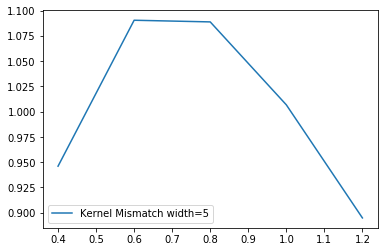

In [160]:
tlen=100000
swidth=5
t, noise =Noise_Gen(tlen,1)
t, sig = Sig_Gen(tlen,50000,swidth,1)
data=sig+noise*0

width_vec=(np.array([i for i in range(5)])-3)+swidth
fitmax=[]

for i in range(len(width_vec)):
    tmask, kernel=Sig_Gen(int(swidth*7),int(swidth*7/2),width_vec[i],1)
    tconv,sigconv=TS_Correlations(t,data,kernel)
    fitmax.append(np.max(np.abs(sigconv)))
    
    

plt.plot(width_vec/swidth, fitmax,label='Kernel Mismatch width=5')
#plt.xlim([.90,1.1])
plt.legend()
plt.show()
#So 10% step seem fine for small

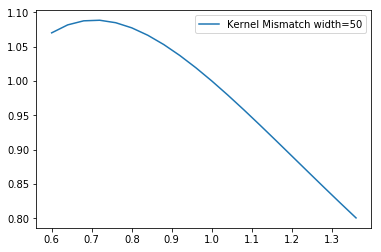

In [62]:
tlen=100000
swidth=50
t, noise =Noise_Gen(tlen,1)
t, sig = Sig_Gen(tlen,50000,swidth,1)
data=sig+noise*0

width_vec=(np.array([i for i in range(20)])-10)*2+swidth
fitmax=[]

for i in range(len(width_vec)):
    tmask, kernel=Sig_Gen(int(swidth*7),int(swidth*7/2),width_vec[i],1)
    tconv,sigconv=TS_Correlations(t,data,kernel)
    fitmax.append(np.max(np.abs(sigconv)))
    
    

plt.plot(width_vec/swidth, fitmax,label='Kernel Mismatch width=50')
#plt.xlim([.90,1.1])
plt.legend()
plt.show()
#So 10% step seem fine for small

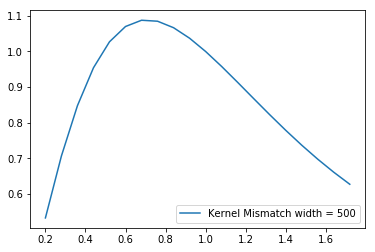

In [63]:
tlen=100000
swidth=500
t, noise =Noise_Gen(tlen,1)
t, sig = Sig_Gen(tlen,50000,swidth,1)
data=sig+noise*0


width_vec=(np.array([i for i in range(20)])-10)*40+swidth
fitmax=[]

for i in range(len(width_vec)):
    tmask, kernel=Sig_Gen(int(swidth*7),int(swidth*7/2),width_vec[i],1)
    tconv,sigconv=TS_Correlations(t,data,kernel)
    fitmax.append(np.max(np.abs(sigconv)))
    
plt.plot(width_vec/swidth, fitmax,label='Kernel Mismatch width = 500')
#plt.xlim([.90,1.1])
plt.legend()
plt.show()
#So 10% step seem fine for large    

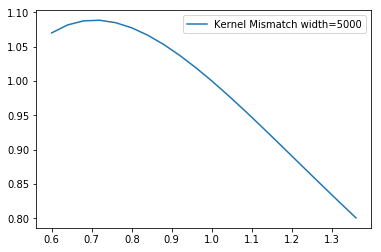

In [64]:
tlen=100000
swidth=5000
t, noise =Noise_Gen(tlen,1)
t, sig = Sig_Gen(tlen,50000,swidth,1)
data=sig+noise*0

width_vec=(np.array([i for i in range(20)])-10)*200+swidth
fitmax=[]

for i in range(len(width_vec)):
    tmask, kernel=Sig_Gen(int(swidth*7),int(swidth*7/2),width_vec[i],1)
    tconv,sigconv=TS_Correlations(t,data,kernel)
    fitmax.append(np.max(np.abs(sigconv)))
    
    

plt.plot(width_vec/swidth, fitmax,label='Kernel Mismatch width=5000')
#plt.xlim([.90,1.1])
plt.legend()
plt.show()
#So 10% step seem fine for small

In [ ]:
# Conclusion, the filter width doesn't need to be matched very well.